# Gray Gas Comparison of single column vs Dynamical
This looks at the effect of circulation on the location and time of the hottest day. It does this by comparing two no-WISHE simulations with vs without dynamics (no dynamics is single column simulation).

In [1]:
import sys
import os

# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat, get_density, virtual_temp, saturation_vapor_pressure, partial_pressure_from_sphum
from isca_tools.utils.constants import kappa, L_v, c_p, c_p_water, rho_water, Stefan_Boltzmann, R, R_v, g
from isca_tools.utils import area_weighting, annual_mean, annual_time_slice, anom_from_annual_mean, print_ds_var_list, numerical
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_temp_adiabat, get_temp_adiabat_surf
from isca_tools.convection.simple_betts_miller import lcl_temp, ref_temp_above_lcl, get_temp_ref
from isca_tools.convection import dry_profile_pressure, moist_profile, potential_temp
import isca_tools.utils.fourier as fourier
from isca_tools.utils.radiation import get_heat_capacity, opd_lw_gray
from isca_tools.plot import colored_line
from isca_tools.thesis.surface_energy_budget import get_temp_fourier_analytic, get_temp_fourier_numerical, get_temp_extrema_analytic,\
    get_temp_extrema_numerical
from isca_tools.plot import label_subplots
from isca_tools.utils.calculus import grad_y
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import optimize, ndimage
import cftime
import calendar
from datetime import timedelta
import warnings
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
plt.rcParams['lines.linewidth'] = 0.8

In [47]:
def shift_time(ds):
    # Make 1st time year 1, day 1, month 1
    # Assume `ds` is your dataset
    n_times = ds.time.size

    # Create new time array starting at year 1, day 1, 12:00 using 360_day calendar
    new_time = [cftime.Datetime360Day(1, 1, 1, 12) + timedelta(days=i) for i in range(n_times)]

    # Assign new time coordinate
    ds['time'] = ('time', new_time)
    return ds

def get_temp_rad(lwdn_sfc, opd):
    # Returns radiative temperature, T_r, such that LW_down = sigma T_r^4 (1 - e^{-opd})
    emission_factor = 1 - np.exp(-opd)
    return (lwdn_sfc / emission_factor / Stefan_Boltzmann)**0.25

In [48]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 't_surf', 'ps', 'precipitation', 'flux_lhe', 'flux_t', 'lwdn_sfc', 'lwup_sfc', 'swdn_sfc']

# # DEFAULT experiment
exp_dir = 'rossbypalooza/depth=20/all_nh/lat_10/no_wishe/'
exp_name = ['base', 'base_col']
exp_dir = 'rossbypalooza/depth=20/all_nh/lat_10/'
exp_name = ['base', 'column/base']
n_exp = len(exp_name)

# Get low level sigma level
namelist = isca_tools.load_namelist(exp_dir+exp_name[0])
p_surface_approx = namelist['spectral_dynamics_nml']['reference_sea_level_press']
sigma_levels_half = np.asarray(namelist['vert_coordinate_nml']['bk'])
sigma_levels_full = np.convolve(sigma_levels_half, np.ones(2)/2, 'valid')
sigma_near_surf = sigma_levels_full[-1]

try:
    w_atm_const = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['w_atm_const']
    drag_const = isca_tools.load_namelist(exp_dir+exp_name[0])['surface_flux_nml']['drag_const']
except KeyError:
    w_atm_const = None
    drag_const = None
evap_prefactor = []
for i in range(n_exp):
    try:
        evap_prefactor.append(isca_tools.load_namelist(exp_dir+exp_name[i])['surface_flux_nml']['land_evap_prefactor'])
    except KeyError:
        evap_prefactor.append(1)
land_h_capacity_prefactor = isca_tools.load_namelist(exp_dir+exp_name[0])['mixed_layer_nml']['land_h_capacity_prefactor']
albedo = isca_tools.load_namelist(exp_dir+exp_name[0])['mixed_layer_nml']['albedo_value']

n_exp = len(exp_name)
lat_range = slice(-40, 90)               # only consider NH and outside deep tropics, and ignore high latitudes as need 2nd harmonic there
pressure_ft = 500
# mass_abs_coef_water = 0.05          # approx mass abosrption coefficient for water (m^2/kg) in longwave according to chatGPT
# use_time_start = cftime.Datetime360Day(10, 1, 1)   # Year 10, January 1st
use_time_start = cftime.Datetime360Day(1, 1, 1)   # Year 1, January 1st
use_time_end = cftime.Datetime360Day(9000, 12, 30)  # Year 9000, December 30th (basically infinity)
ds_base = []
for i in tqdm(range(n_exp)):
    ds_use = isca_tools.load_dataset(exp_dir + exp_name[i], decode_times=True).isel(lon=0, drop=True)
    ds_use = ds_use[var_keep]
    ds_use = ds_use.sel(time=slice(use_time_start, use_time_end)).sel(lat=lat_range)
    # ds_use['water_depth'] = get_water_column_depth(ds_use.sphum.transpose("pfull", "time", "lat"), ds_use.pfull.values*100)
    ds_use = ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')      # only keep lowest level
    # Compute variables required for flux breakdown
    ds_use['emission_factor'] = ds_use.lwdn_sfc/(Stefan_Boltzmann*ds_use.temp.isel(pfull=0)**4)
    ds_use['temp_diseqb'] = ds_use.t_surf - ds_use.temp.isel(pfull=0)
    ds_use['temp_diseqb_rad'] = ds_use.temp.isel(pfull=0) - get_temp_rad(ds_use.lwdn_sfc, opd_lw_gray(ds_use.lat))
    ds_use['rh'] = ds_use.sphum.isel(pfull=0) / sphum_sat(ds_use.temp.isel(pfull=0), ds_use.ps*sigma_near_surf)
    ds_use['lw_net'] = ds_use.lwup_sfc - ds_use.lwdn_sfc
    ds_use['flux_sfc_dn_net'] = ds_use.swdn_sfc + ds_use.lwdn_sfc - ds_use.lwup_sfc - ds_use.flux_lhe - ds_use.flux_t
    # Compute deviation from lowest level and radiative temperature given surface optical depth
    ds_use['mse'] = moist_static_energy(ds_use.temp, ds_use.sphum, ds_use.height).isel(pfull=0)
    ds_use['mse_ft'] = moist_static_energy(ds_use.temp, sphum_sat(ds_use.temp, ds_use.pfull*100), ds_use.height).isel(pfull=1)
    ds_use['mse_lapse'] = ds_use['mse'] - ds_use['mse_ft']

    ds_use = shift_time(ds_use)       # shift so first is year 1, month 1, day 1
    ds_base.append(ds_use.load())      # only keep after spin up
for i in range(1, n_exp):
    xr.testing.assert_identical(ds_base[0].time, ds_base[i].time)      # ensure times are the same
mixed_layer_depth = {'ocean': namelist['mixed_layer_nml']['depth']}
mixed_layer_depth['land'] = namelist['mixed_layer_nml']['land_h_capacity_prefactor'] * mixed_layer_depth['ocean']
ind_surf = 0
ind_ft = 1
pressure_ft_actual = float(ds_base[0].pfull[ind_ft]*100)
p_lowlevel = float(ds_base[0].pfull[ind_surf]*100)

  0%|          | 0/2 [00:00<?, ?it/s]

/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')
/Users/joshduffield/Documents/StAndrews/Isca/isca_tools/utils/load.py:57: UserWarning: First month saved is 121 not 1.
  warnings.warn(f'First month saved is {first_month} not 1.')


In [49]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
im_sz = 1.4     # larger makes images larger, keeping ar the same
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5, 'two_thirds': 4.5}        # width in inches
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])
ax_lims_lat = [np.floor(ds_base[0].lat[0]), np.ceil(ds_base[0].lat[-1])]
ax_lims_time = [0, 360]

leg_info = {'handlelength': 1, 'labelspacing': 0.2, 'columnspacing': 0.9, 'handletextpad': 0.5}       # info for legend
def add_legend(ax, handles=None, labels=None, ncol=1, title=None, loc=None, frameon=False, edgecolor="k", borderpad=None,
               labelspacing=leg_info['labelspacing'], handlelength=leg_info['handlelength'],
               columnspacing=leg_info['columnspacing'], handletextpad=leg_info['handletextpad']):
    if handles is None:
        return ax.legend(ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                 labelspacing=labelspacing, handlelength=handlelength,
                 columnspacing=columnspacing, handletextpad=handletextpad)
    else:
        return ax.legend(handles, labels, ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                         labelspacing=labelspacing, handlelength=handlelength,
                         columnspacing=columnspacing, handletextpad=handletextpad)

In [50]:
job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, exp_name[0], 'land.nc')
# fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
# isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
lat_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[0]  # get the latitude coordinates of land
lat_ocean = isca_tools.utils.land.get_ocean_coords(land_file=land_file_name)[0]
lat_land_min = (lat_land.min() + lat_ocean.max()) / 2           # show land in plots as average between ocean and land extrema
lat_land_max = 90

# Add heat capacity to dataset
for i in range(n_exp):
    ds_base[i]['heat_capacity'] = get_heat_capacity(c_p_water, rho_water, mixed_layer_depth['land'] *
                                                    (ds_base[i].lat > lat_land_min) + mixed_layer_depth['ocean'] *
                                                      (ds_base[i].lat < lat_land_min))
    # Record evaporative fraction as well
    ds_base[i]['evap_frac'] = (ds_base[i].lat > lat_land_min) * evap_prefactor[i] + (ds_base[i].lat < lat_land_min)

In [51]:
def show_land(ax, lat_land_min=lat_land_min, lat_land_max=lat_land_max, lat_ax='x', color_land='g', lw_land=4):
    if not isinstance(ax, (list, np.ndarray)):
        raise ValueError(f'ax should be a list or numpy array, but given is {type(ax)}')
    for i in range(len(ax)):
        if lat_ax == 'x':
            var = ax[i].get_ylim()[0]
            xlim = ax[i].get_xlim()
            ax[i].hlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
            ax[i].set_ylim(var, ax[i].get_ylim()[1])
            ax[i].set_xlim(xlim)
        elif lat_ax == 'y':
            var = ax[i].get_xlim()[0]
            ylim = ax[i].get_ylim()
            ax[i].vlines(var, lat_land_min, lat_land_max, color=color_land, lw=lw_land)
            ax[i].set_xlim(var, ax[i].get_xlim()[1])
            ax[i].set_ylim(ylim)
        else:
            raise ValueError(f'lat_ax must be either x or y, but {lat_ax} was given.')

## Get Annual average dataset
Get one dataset for each simulation. Also, get the normal simulation which includes dynamics for comparison.

In [52]:
def get_smooth_array(ds, window=20, dim='dayofyear'):
    if dim not in ds.dims:
        raise ValueError(f"Dimension '{dim}' not found in dataset.")
    ds_use = ds.pad({dim: window // 2}, mode="wrap")
    # Apply rolling mean
    ds_use = ds_use.rolling({dim: window}, center=True).mean()
    # Remove padding to keep the original time length
    ds_use = ds_use.isel({dim: slice(window // 2, -window // 2)})
    return ds_use

def get_annual_mean_at_hour(ds, hour=12):
    # Returns dataset wth only a given hour at each day, and then for each day average over all years of dataset.
    # Returned dataset only has 360 time values (one for each year)
    if hour not in ds.time.dt.hour:
        raise ValueError(f'hour must be in {np.unique(ds.time.dt.hour)} but {hour} given')
    ds_use = ds.where(ds.time.dt.hour == hour, drop=True)
    return ds_use.groupby("time.dayofyear").mean(dim="time")


smooth_sz = 20   # smooth over 20 days
ds = [get_smooth_array(get_annual_mean_at_hour(ds_base[i]), smooth_sz) for i in range(n_exp)]
color_exp = [default_colors[0], default_colors[1], default_colors[3]]
n_lat = ds[0].lat.size

In [53]:
def get_extrema_coordinates(da, max=True):
    """
    Find the coordinates of the maximum value in a 2D xarray DataArray.

    Parameters:
    da (xarray.DataArray): A 2D DataArray with unknown coordinate names.

    Returns:
    dict: A dictionary with the coordinate names, their values, and the max value.
    """
    if da.ndim != 2:
        raise ValueError("Input DataArray must be 2D.")

    # Get dimension names dynamically
    dim1, dim2 = da.dims  # First and second dimension names

    # Find max index
    if max:
        max_index = da.argmax().item()  # Get flattened index of max
    else:
        max_index = da.argmin().item()
    max_coords = np.unravel_index(max_index, da.shape)  # Convert to 2D indices

    # Extract the coordinate values dynamically
    coord1_max = da[dim1].values[max_coords[0]]
    coord2_max = da[dim2].values[max_coords[1]]
    max_value = da.values[max_coords]

    return {dim1: coord1_max, dim2: coord2_max, "extrema_value": max_value}

## Surface Temperature
The surface temperature distributions are compared below. The crosses indicate the hottest day of the year, it occurs later and at the lowest land latitude for the SOCRATES simulation.

It is not surprising that the SOCRATES simulation is almost uniformly colder, as it has a larger surface albedo.

{'dayofyear': 207, 'lat': 37.67308962904533, 'extrema_value': 309.05487}
{'dayofyear': 219, 'lat': 23.720173933534745, 'extrema_value': 308.81845}


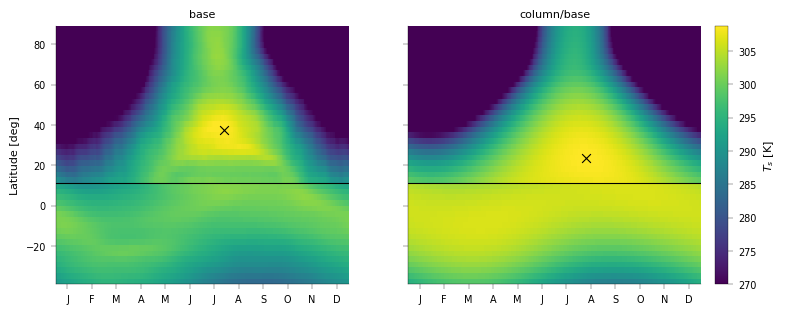

In [20]:
fig, ax = plt.subplots(1, n_exp, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
for i in range(n_exp):
    im = ax[i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].t_surf.transpose(), vmin=270, vmax=ds[-1].t_surf.max())
    var = get_extrema_coordinates(ds[i].t_surf, 'max')
    print(var)
    ax[i].scatter(var['dayofyear'], var['lat'], color='k', marker='x', s=40)
fig.colorbar(im, ax=ax.ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_s$ [K]')
# im = ax[2].pcolormesh(ds['diff'].dayofyear, ds['diff'].lat, ds['diff'].t_surf.transpose(), vmin=-40, vmax=40, cmap='bwr')
# fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='$T_s$ [K]')
for i, key in enumerate(ds):
    ax[i].set_title(exp_name[i])
    ax[i].axhline(lat_land_min, color='k' if i<=1 else 'k')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

## Surface Fluxes
Here, we do a sanity check that our computations of surface fluxes match the simulated values well.
### Latent Heat
There is a non-zero error, but this is likely because we are doing the calculation from the averaged quantities, not doing the computation first and then averaging. The magnitude of the error increases as the size of the flux increases.

In [41]:
def get_latent_heat(temp_surf, temp_diseqb, rh, evap_fraction=1, p_surf=p_surface_approx, wind_speed=w_atm_const,
                    drag_coef=drag_const, sigma=sigma_near_surf, virtual=False):
    p_a = p_surf * sigma
    temp_a = temp_surf - temp_diseqb
    sphum_a = rh * sphum_sat(temp_a, p_a)
    if virtual:
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return evap_fraction * L_v * drag_coef * rho * wind_speed * (sphum_sat(temp_surf, p_surf) - sphum_a)

In [71]:
w_atm_const=10
drag_const=0.0009

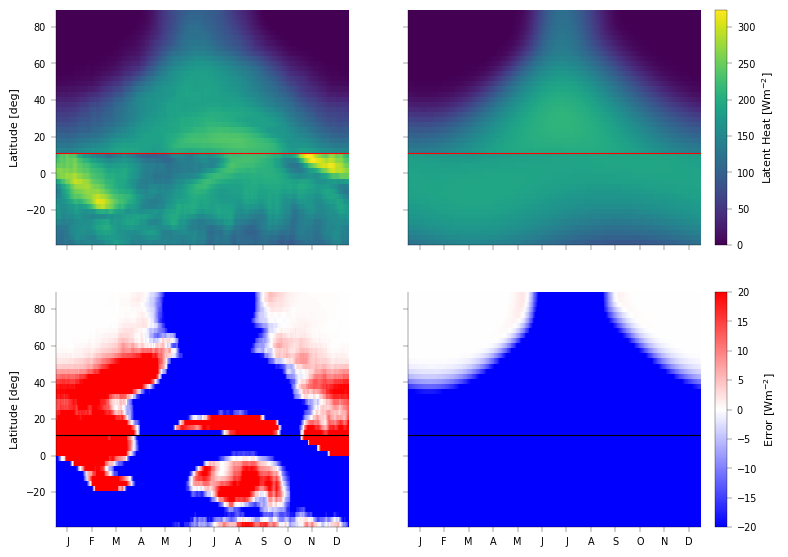

In [75]:
fig, ax = plt.subplots(2, n_exp, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'] * 2)
for i in range(n_exp):
    im = ax[0, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].flux_lhe.transpose(), vmin=0, vmax=ds[0].flux_lhe.max())
    if i == 1:
        fig.colorbar(im, ax=ax[0].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Latent Heat [Wm$^{-2}$]')
    var = get_latent_heat(ds[i].t_surf, ds[i].temp_diseqb, ds[i].rh, ds[i].evap_frac)
    im = ax[1, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].flux_lhe.transpose()-var.transpose(), vmin=-20, vmax=20, cmap='bwr')
    if i == 1:
        fig.colorbar(im, ax=ax[1].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Error [Wm$^{-2}$]')
    ax[0, i].axhline(lat_land_min, color='r')
    ax[1, i].axhline(lat_land_min, color='k')
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
plt.show()

### Sensible Heat
The calculation for sensible heat is very close to the simulated.

In [73]:
def get_sensible_heat(temp_surf, temp_diseqb, p_surf=p_surface_approx, wind_speed=w_atm_const, drag_coef=drag_const,
                      sigma=sigma_near_surf, virtual=False, rh=None):
    p_a = p_surf * sigma
    temp_a = temp_surf - temp_diseqb
    if virtual:
        sphum_a = rh * sphum_sat(temp_a, p_a)
        rho = get_density(temp_a, p_a, sphum_a)
    else:
        rho = get_density(temp_a, p_a)
    return c_p * drag_coef * rho * wind_speed * (temp_surf * (1 - sigma ** (-kappa)) + temp_diseqb * sigma ** (-kappa))

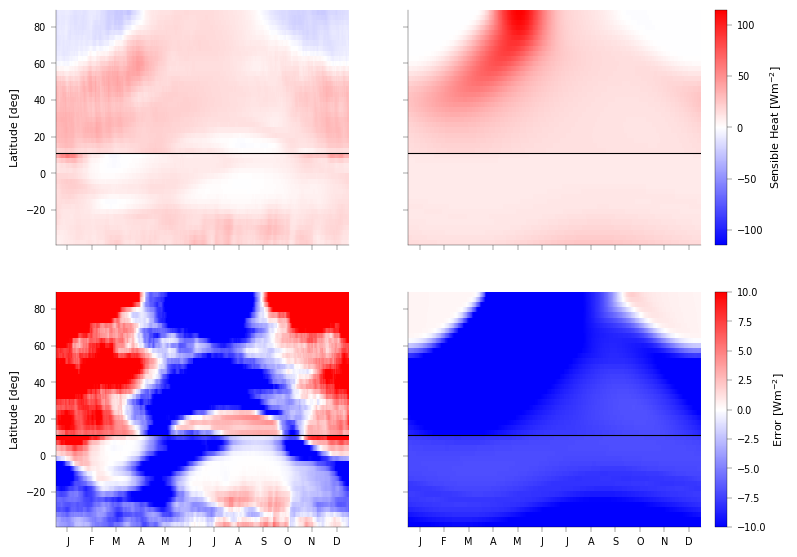

In [76]:
fig, ax = plt.subplots(2, n_exp, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'] * 2)
for i in range(n_exp):
    im = ax[0, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].flux_t.transpose(), vmin=-ds[-1].flux_t.max(), vmax=ds[-1].flux_t.max(), cmap='bwr')
    if i == 1:
        fig.colorbar(im, ax=ax[0].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Sensible Heat [Wm$^{-2}$]')
    var = get_sensible_heat(ds[i].t_surf, ds[i].temp_diseqb)
    im = ax[1, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].flux_t.transpose()-var.transpose(), vmin=-10, vmax=10, cmap='bwr')
    if i == 1:
        fig.colorbar(im, ax=ax[1].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Error [Wm$^{-2}$]')
    ax[0, i].axhline(lat_land_min, color='k')
    ax[1, i].axhline(lat_land_min, color='k')
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
plt.show()

### Longwave

In [77]:
def get_lwdn_sfc(temp_surf, temp_diseqb, temp_diseqb_rad, opd):
    emission_factor = 1 - np.exp(-opd)
    temp_rad = temp_surf - temp_diseqb - temp_diseqb_rad
    return Stefan_Boltzmann * temp_rad**4 * emission_factor

In [85]:
ds[0].temp_diseqb_rad.sel(lat=slice(20, 70)).median()

<xarray.DataArray 'temp_diseqb_rad' ()> Size: 8B
array(5.27350754)

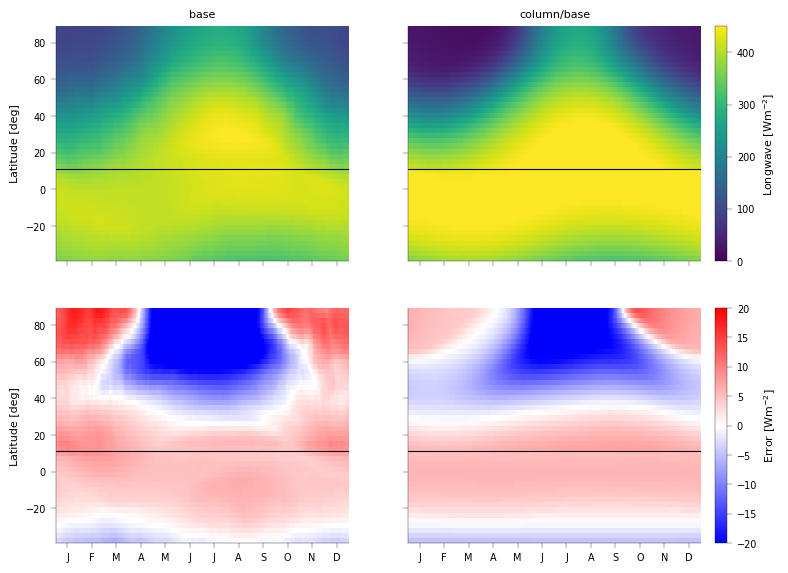

In [88]:
fig, ax = plt.subplots(2, n_exp, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'] * 2)
for i in range(n_exp):
    ax[0, i].set_title(exp_name[i])
    im = ax[0, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].lwdn_sfc.transpose(), vmin=0, vmax=ds[0].lwdn_sfc.max())
    if i == 1:
        fig.colorbar(im, ax=ax[0].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Longwave [Wm$^{-2}$]')
    var = get_lwdn_sfc(ds[i].t_surf, ds[i].temp_diseqb, 5, opd_lw_gray(ds[i].lat))
    im = ax[1, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].lwdn_sfc.transpose()-var.transpose(), vmin=-20, vmax=20, cmap='bwr')
    if i == 1:
        fig.colorbar(im, ax=ax[1].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Error [Wm$^{-2}$]')
    ax[0, i].axhline(lat_land_min, color='k')
    ax[1, i].axhline(lat_land_min, color='k')
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
plt.show()

### Shortwave
Shortwave reaching the surface should be the same for both simulations. We check this here.

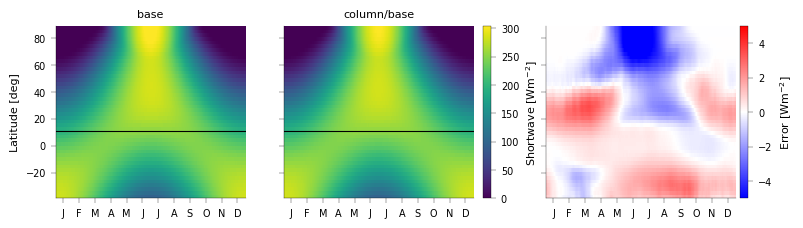

In [94]:
fig, ax = plt.subplots(1, n_exp+1, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'] * 2)
for i in range(n_exp):
    ax[i].set_title(exp_name[i])
    im = ax[i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].swdn_sfc.transpose(), vmin=0, vmax=ds[1].swdn_sfc.max())
    if i == 1:
        fig.colorbar(im, ax=ax[:i+1].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Shortwave [Wm$^{-2}$]')
    # var = get_swdn_sfc_zillman(ds[i].swdn_toa, ds[i].soc_coszen, ds[i].sphum.isel(pfull=ind_surf), zillman_param[0],
    #                        zillman_param[1], zillman_param[2])
    # im = ax[1, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].swdn_sfc.transpose()-var.transpose(), vmin=-30, vmax=30, cmap='bwr')
    # if i == 2:
    #     fig.colorbar(im, ax=ax[1].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Error [Wm$^{-2}$]')
    ax[i].axhline(lat_land_min, color='k')
im = ax[2].pcolormesh(ds[0].dayofyear, ds[0].lat, (ds[1].swdn_sfc-ds[0].swdn_sfc).transpose(), vmin=-5, vmax=5, cmap='bwr')
fig.colorbar(im, ax=ax[2:].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Error [Wm$^{-2}$]')
ax[0].set_xticks(*month_ticks)
ax[0].set_ylabel('Latitude [deg]')
plt.show()

### Temperature tendency
The theoretical temperature tendency clearly does not match the actual temperature tendency, so this is problematic for estimating the maximum temperature and where it occurs.

In [55]:
def get_temp_tendency(temp_surf, swdn_toa, coszen, temp_diseqb,
                      rh, heat_capacity, p_surf=p_surface_approx, wind_speed=w_atm_const,
                      drag_q=drag_const, sigma=sigma_near_surf,
                      zillman_empirical_param=zillman_param, evap_fraction=1):
    lwup_sfc = Stefan_Boltzmann * temp_surf**4
    lwdn_sfc = get_lwdn_sfc_brutsaert(temp_surf, temp_diseqb, rh=rh, p_surf=p_surf, sigma=sigma)
    lhup = get_latent_heat(temp_surf, temp_diseqb, rh, evap_fraction, p_surf, wind_speed, drag_q, sigma, virtual=False)
    shup = get_sensible_heat(temp_surf, temp_diseqb, p_surf, wind_speed, drag_q, sigma, virtual=False)
    temp_a = temp_surf - temp_diseqb
    sphum_a = rh * sphum_sat(temp_a, sigma * p_surf)
    swdn_sfc = get_swdn_sfc_zillman(swdn_toa, coszen, sphum_a, zillman_empirical_param[0], zillman_empirical_param[1], zillman_empirical_param[2],
                                    p_surf, sigma)
    return (swdn_sfc + lwdn_sfc - lwup_sfc - lhup - shup)/heat_capacity

{'dayofyear': 232, 'lat': 46.044726631101675, 'extrema_value': 308.3549}
{'dayofyear': 233, 'lat': 40.46364817811504, 'extrema_value': 310.0685}
{'dayofyear': 211, 'lat': 37.67308962904533, 'extrema_value': 316.7788}


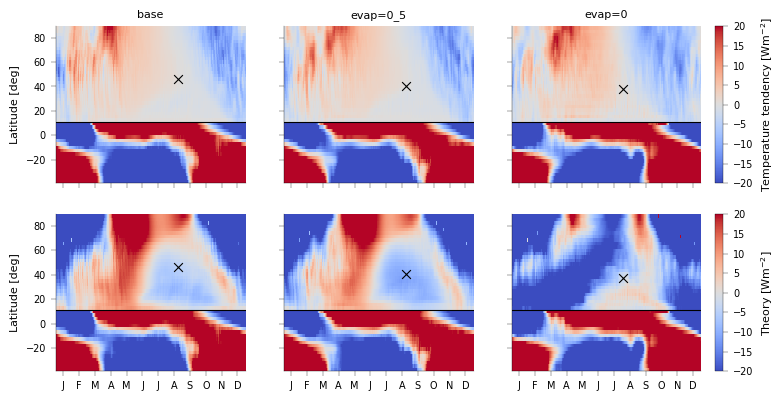

In [74]:
fig, ax = plt.subplots(2, n_exp, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz * width['one_col'] * 2)
for i in range(n_exp):
    ax[0, i].set_title(exp_name[i])
    im = ax[0, i].pcolormesh(ds[i].dayofyear, ds[i].lat, ds[i].flux_sfc_dn_net.transpose(), vmin=-20, vmax=20, cmap='coolwarm')
    if i == 2:
        fig.colorbar(im, ax=ax[0].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Temperature tendency [Wm$^{-2}$]')
    var = get_temp_tendency(ds[i].t_surf, ds[i].swdn_toa, ds[i].soc_coszen, ds[i].temp_diseqb, ds[i].rh,
                            ds[i].heat_capacity, evap_fraction=ds[i].evap_frac) * ds[i].heat_capacity
    im = ax[1, i].pcolormesh(ds[i].dayofyear, ds[i].lat, var.transpose(), vmin=-20, vmax=20, cmap='coolwarm')
    if i == 2:
        fig.colorbar(im, ax=ax[1].ravel(), orientation="vertical", fraction=0.05, pad=0.02, label='Theory [Wm$^{-2}$]')
    ax[0, i].axhline(lat_land_min, color='k')
    ax[1, i].axhline(lat_land_min, color='k')
    var = get_extrema_coordinates(ds[i].t_surf, 'max')
    print(var)
    ax[0, i].scatter(var['dayofyear'], var['lat'], color='k', marker='x', s=40)
    ax[1, i].scatter(var['dayofyear'], var['lat'], color='k', marker='x', s=40)
ax[0, 0].set_xticks(*month_ticks)
ax[0, 0].set_ylabel('Latitude [deg]')
ax[1, 0].set_ylabel('Latitude [deg]')
plt.show()

### Latitudinal variation in temperature
Below we see that on a given day, the latitudinal variation is much larger over land for zero evaporation.

It is also interesting that the ocean in the southern hemisphere is colder for zero land evaporation, despite there being no change to the ocean between the simulations. This maybe because there is less moisture over the ocean, simply because less is advected from over land. Thus, there is less downward longwave radiation reaching the surface.

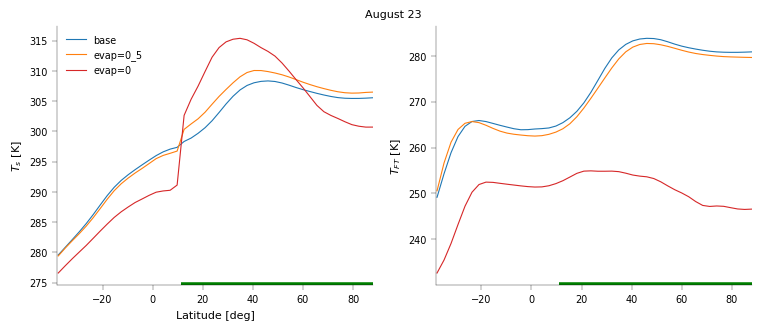

In [20]:
def get_month_day_from_ind(day_index):
    month = day_index // 30 + 1  # +1 for 1-based month
    day = day_index % 30 + 1     # +1 for 1-based day
    return month, day

linestyle_exp = ['-', '--', ':']
fig, ax = plt.subplots(1, 2, sharex=True)
isca_tools.plot.fig_resize(fig, 2*im_sz*width['one_col'])
day_plot = get_extrema_coordinates(ds[0].t_surf, 'max')['dayofyear']
for i in range(n_exp):
    # for j in range(n_exp):
    ax[0].plot(ds[i].lat, ds[i].t_surf.isel(dayofyear=day_plot), color=color_exp[i],
            label=exp_name[i])
    # ax[0].plot(ds[i].lat, temp_surf_eqb_day[i], color=color_exp[i], linestyle=':')
    ax[1].plot(ds[i].lat, ds[i].temp.isel(dayofyear=day_plot, pfull=ind_ft), color=color_exp[i])
ax[0].legend()
ax[0].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('$T_s$ [K]')
ax[1].set_ylabel('$T_{FT}$ [K]')
ax[0].set_xlim(ax_lims_lat)
var = get_month_day_from_ind(day_plot)
label_use = f'{calendar.month_name[var[0]]} {var[1]}'
fig.suptitle(label_use, fontsize=8, y=0.93)
show_land(ax)
plt.show()

### Seasonal variation of RH and $T_{diseqb}$
Below, we look at a single latitude, and plot the variation throughout the year of relative humidity and disequilibrium temperature. The idea being, that both of these variables enter the surface energy budget.

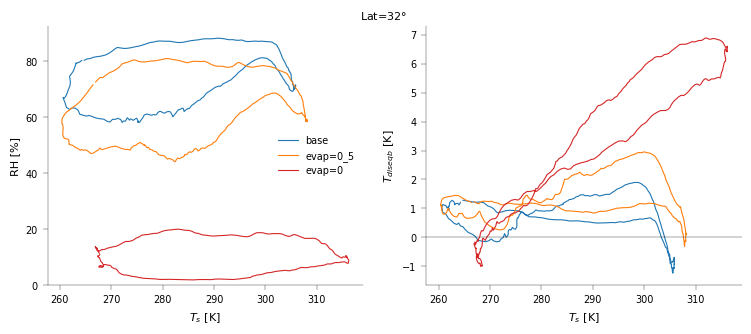

In [85]:
fig, ax = plt.subplots(1, 2, sharex=True)
isca_tools.plot.fig_resize(fig, 2*im_sz*width['one_col'])
lat_plot_ind = 25
for i in range(n_exp):
    ax[0].plot(ds[i].t_surf.isel(lat=lat_plot_ind), ds[i].rh.isel(lat=lat_plot_ind)*100, label=exp_name[i], color=color_exp[i])
    ax[1].plot(ds[i].t_surf.isel(lat=lat_plot_ind), ds[i].temp_diseqb.isel(lat=lat_plot_ind), color=color_exp[i])
# ax.plot(ds_dyn.t_surf.isel(lat=lat_plot_ind), ds_dyn.temp_diseqb.isel(lat=lat_plot_ind), label='Gray (dynamic)', color='k')
ax[0].set_xlabel('$T_s$ [K]')
ax[0].set_ylabel('RH [%]')
ax[1].set_xlabel('$T_s$ [K]')
ax[1].set_ylabel('$T_{diseqb}$ [K]')
ax[0].legend()
ax[0].set_ylim(0, ax[0].get_ylim()[1])
ax[1].axhline(0, color='k', lw=ax_linewidth)
fig.suptitle(f'Lat={ds[0].lat[lat_plot_ind].values:.0f}$\degree$', fontsize=8, y=0.93)
plt.show()

#### Approximate $SW^{\downarrow}$ including effect of water vapour feedback
Below, we see that just including the effect of surface temperature on water vapour in the atmosphere, captures that less sunlight reaches the surface in autumn than spring due to more being absorbed in the atmosphere.

I also show that this effect is not captured if we assume no temperature dependence on $\tau_{sw}$ and just set it to a constant.

### Temperature Tendency
We can combine our approximate estimates for the various surface heat fluxes which depend only on surface temperature, and TOA insolation, and plot the temperature tendency for various surface temperature values.

The zero crossing of this temperature tendency is thus the equilibrium temperature for that particular insolation and choice of parameters.

Land responds very quickly to changes in energy input, so it is reasonable to expect that at any given time, the surface temperature is equal to this equilibrium temperature.

So a naive estimate for the hottest day at a given latitude, would just be the equilibrium temperature with given parameters and the maximum insolation.

In [22]:
# def get_land_median_var(ds, var):
#     return float(ds[var].sel(lat=slice(lat_land_min, np.inf)).median())
# const_params = {var: get_land_median_var(ds[0], var) for var in ['ps', 'rh', 'temp_diseqb']}
# const_params

In [23]:
def find_root_with_sign_check(f, args, x0=300, epsilon=1e-3, search_step=5, max_attempts=10):
    """
    Find a root of f(x) using the secant method, starting at x0.
    Only accept root if f(x - ε) > 0 and f(x + ε) < 0. I.e. if is a maxima
    If not, search around x0 for another root.
    search_range is in kelvin

    """
    attempts = 0
    offset = 0
    while attempts < max_attempts:
        x_start = x0 + offset

        try:
            # Use secant method: requires two initial points
            res = scipy.optimize.root_scalar(f, x0=x_start, x1=x_start + 0.1, method='secant', args=args)

            if res.converged:
                x_root = res.root
                # Only return if maxima
                f_before = f(x_root - epsilon, *args)
                f_after = f(x_root + epsilon, *args)

                if f_before > 0 and f_after < 0:
                    return x_root
                # Otherwise: try next offset
        except ValueError:
            pass  # silently skip if secant fails

        # Try a new offset (symmetric search around x0)
        attempts += 1
        offset = ((attempts + 1) // 2) * search_step * (-1)**attempts
    raise RuntimeError("No suitable root found after all attempts.")

In [52]:
def get_temp_equilibrium(swdn_toa, coszen, temp_diseqb,
                         rh, heat_capacity, p_surf=p_surface_approx, wind_speed=w_atm_const,
                         drag_q=drag_const, sigma=sigma_near_surf,
                         zillman_empirical_param=zillman_param, evap_fraction=1, initial_guess=300):
    # Solve for temp tendency equals zero to get equilibrium temperature
    var = find_root_with_sign_check(get_temp_tendency, args=(swdn_toa, coszen, temp_diseqb, rh, heat_capacity, p_surf, wind_speed, drag_q, sigma,
                                                             zillman_empirical_param, evap_fraction), x0=initial_guess)
    return var
#     # var = scipy.optimize.minimize_scalar(get_temp_tendency, bracket=bracket,
#     #                                      args=(swdn_toa, coszen, temp_diseqb, rh, heat_capacity, p_surf, wind_speed, drag_q, sigma,
#     #                                        zillman_empirical_param, evap_fraction))
#     var = scipy.optimize.root_scalar(get_temp_tendency, bracket=bracket,
#                                      args=(swdn_toa, coszen, temp_diseqb, rh, heat_capacity, p_surf, wind_speed, drag_q, sigma,
#                                            zillman_empirical_param, evap_fraction))
#     if var.converged:
#         return var.root
#     else:
#         raise ValueError(f'After {var.iterations}, not converged')
# get_temp_equilibrium(ds_use.swdn_toa, ds_use.soc_coszen, ds_use.temp_diseqb, ds_use.rh,
#                      ds_use.heat_capacity, evap_fraction=ds_use.evap_frac)

## Hottest Day as function of latitude
Below, we see that the theoretical net flux into the surface is not zero on the hottest day. This means that the hottest day of the year as a function of latitude, using this theoretical framework for temperature tendency is not particularly good.

The main issue is at high latitudes, where the estimates of the LW, LH and SH are over-estimated I think. There is a clear correspondence between the over-estimate in net flux, and the temperature over-estimate in the left plot.

The evap=0 situation is more complicated, when we can't even get a prediction because (I think) the temperature tendency is always positive i.e. a runaway greenhouse type effect.

In [29]:
temp_surf_eqb_hottest = np.full((n_exp, n_lat), np.nan)
net_flux_sfc_dn_hottest_theory = np.full((n_exp, n_lat), np.nan)
net_flux_sfc_dn_hottest = np.full((n_exp, n_lat), np.nan)
pbar = tqdm(total=n_exp*n_lat)
for i in range(n_exp):
    for j in range(n_lat):
        ind_use = ds[i].t_surf.isel(lat=j).argmax()
        ds_use = ds[i].isel(lat=j, dayofyear=ind_use)
        net_flux_sfc_dn_hottest_theory[i, j] = get_temp_tendency(ds_use.t_surf, ds_use.swdn_toa, ds_use.soc_coszen, ds_use.temp_diseqb, ds_use.rh,
                                                             ds_use.heat_capacity, evap_fraction=ds_use.evap_frac) * ds_use.heat_capacity
        net_flux_sfc_dn_hottest[i, j] = ds_use.flux_sfc_dn_net
        try:
            temp_surf_eqb_hottest[i, j] = get_temp_equilibrium(ds_use.swdn_toa, ds_use.soc_coszen, ds_use.temp_diseqb, ds_use.rh,
                                                 ds_use.heat_capacity, evap_fraction=ds_use.evap_frac)
        except RuntimeError as var:
            print(exp_name[i], f"lat={ds_use.lat:.0f}", var)
        pbar.update(1)

  0%|          | 0/138 [00:00<?, ?it/s]

evap=0 lat=21 No suitable root found after all attempts.
evap=0 lat=24 No suitable root found after all attempts.
evap=0 lat=27 No suitable root found after all attempts.


In [31]:
net_flux_sfc_dn_hottest

array([[-1.57580686,  0.80418968, -0.33439979,  0.52378196,  1.05711997,
        -0.11488714,  0.00448365,  0.15759583,  0.32347974, -0.12702584,
         0.65494215,  1.92846584,  0.53465408,  0.10372286,  0.32953167,
        -0.12830029,  0.81706041,  0.12761669,  0.13742565, -0.06619006,
        -0.29122144, -0.46769866, -0.48423862, -0.22800271, -0.64021075,
        -0.18261543, -0.26284191,  0.18930046,  0.25866422,  0.42459956,
         0.43378019,  0.53346956,  0.53453761,  0.6351645 ,  0.58574265,
         0.49857187,  0.63895458,  0.5620603 ,  0.56477833,  0.51958829,
         0.43584034,  0.44823009,  0.35192028,  0.40966606,  0.40553036,
         0.42713529],
       [-1.78227079,  0.33958626,  1.83202899,  0.36376229, -0.48231927,
        -0.56691438, -0.07124853,  0.14662948, -0.08522439,  0.545237  ,
        -0.03039932,  4.18073082,  0.34564105,  0.53760815,  0.33211288,
         0.05211601,  0.44037524,  0.11777534, -0.10815992, -0.20459019,
        -0.36192641, -0.36759

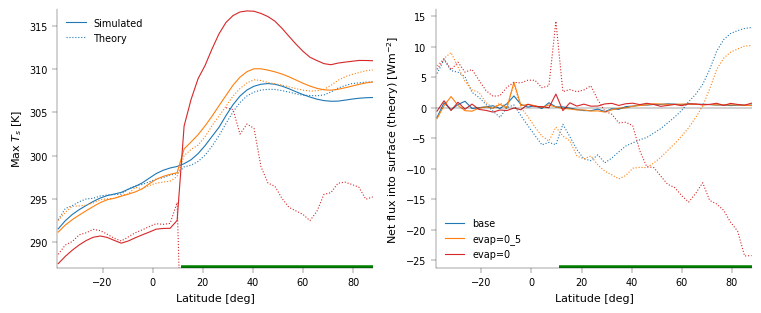

In [36]:
fig, ax = plt.subplots(1, 2, sharex=True)
isca_tools.plot.fig_resize(fig, 2*im_sz*width['one_col'])
for i in range(n_exp):
    ax[0].plot(ds[i].lat, ds[i].t_surf.max(dim='dayofyear'), color=color_exp[i], label='Simulated' if i==0 else None)
    ax[0].plot(ds[i].lat, temp_surf_eqb_hottest[i], color=color_exp[i], linestyle=':', label='Theory' if i==0 else None)
    ax[1].plot(ds[i].lat, net_flux_sfc_dn_hottest[i], color=color_exp[i], label=exp_name[i])
    ax[1].plot(ds[i].lat, net_flux_sfc_dn_hottest_theory[i], color=color_exp[i], linestyle=':')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_xlim(ax_lims_lat)
ax[0].set_ylim(287, 317)
show_land(ax)
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
ax[1].set_ylabel('Net flux into surface (theory) [Wm$^{-2}$]')
ax[0].set_ylabel('Max $T_s$ [K]')
plt.show()

In [33]:
temp_surf_eqb_day = np.full((n_exp, n_lat), np.nan)
day_plot = get_extrema_coordinates(ds[0].t_surf, 'max')['dayofyear']
pbar = tqdm(total=n_exp*n_lat)
for i in range(n_exp):
    for j in range(n_lat):
        ds_use = ds[i].isel(lat=j, dayofyear=day_plot)
        try:
            temp_surf_eqb_day[i, j] = get_temp_equilibrium(ds_use.swdn_toa, ds_use.soc_coszen, ds_use.temp_diseqb, ds_use.rh,
                                                 ds_use.heat_capacity, evap_fraction=ds_use.evap_frac)
        except RuntimeError as var:
            print(exp_name[i], f"lat={ds_use.lat:.0f}", var)
        pbar.update(1)

  0%|          | 0/138 [00:00<?, ?it/s]

evap=0 lat=24 No suitable root found after all attempts.
evap=0 lat=27 No suitable root found after all attempts.
evap=0 lat=29 No suitable root found after all attempts.
evap=0 lat=68 No suitable root found after all attempts.
evap=0 lat=71 No suitable root found after all attempts.
evap=0 lat=74 No suitable root found after all attempts.
evap=0 lat=77 No suitable root found after all attempts.
evap=0 lat=82 No suitable root found after all attempts.
evap=0 lat=85 No suitable root found after all attempts.
evap=0 lat=88 No suitable root found after all attempts.


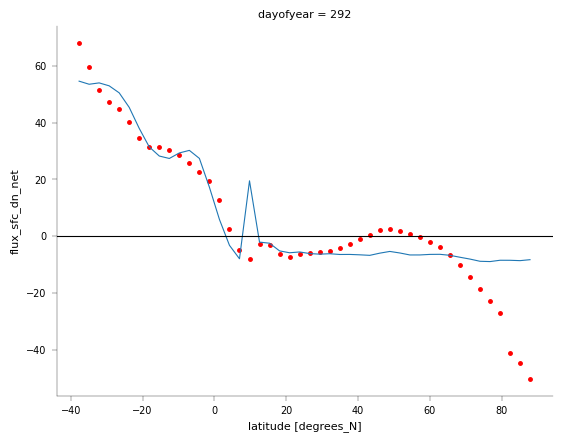

In [39]:
day_plot=291
ds[2].isel(dayofyear=day_plot).flux_sfc_dn_net.plot()
for j in range(n_lat):
    ds_use = ds[1].isel(lat=j, dayofyear=day_plot)
    var = get_temp_tendency(ds_use.t_surf, ds_use.swdn_toa, ds_use.soc_coszen, ds_use.temp_diseqb, ds_use.rh,
                                                         ds_use.heat_capacity, evap_fraction=ds_use.evap_frac)
    plt.scatter(ds_use.lat, var*ds_use.heat_capacity, color='r')
plt.axhline(0, color='k')

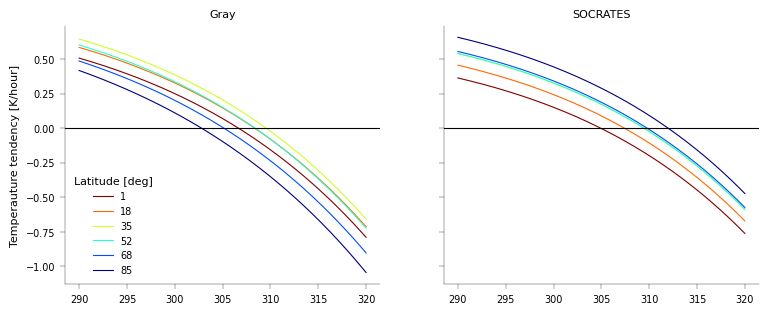

In [48]:
temp_tendency_t_surf_vals = np.linspace(290, 320, 800)
temp_surf_eqb = {key: np.zeros(ds['gray'].lat.size) for key in ['gray', 'soc', 'gray_insolation', 'soc_insolation',
                                                                'gray_param', 'soc_param', 'gray_param_dyn']}
lat_plot_ind = np.arange(0, ds['gray'].lat.size, 6)
cmap_use = [plt.get_cmap('jet')(i) for i in np.linspace(0, 1, lat_plot_ind.size)][::-1]

ind_lat_ref = np.argmin(np.abs(ds['soc'].lat.values-50))        # use parameters at this latitude
ds_ref = {key: ds[key].isel(lat=ind_lat_ref, dayofyear=ds[key].t_surf.isel(lat=ind_lat_ref).argmax()) for key in ['gray', 'soc']}

fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, im_sz*width['one_col']*2)
j=0
for i in range(0, ds['gray'].lat.size):
    var = get_temp_tendency(temp_tendency_t_surf_vals, float(ds['gray']['swdn_toa'].isel(lat=i).max()),
                            albedo['gray'], float(opd_lw_gray(ds['gray'].lat.isel(lat=i))), opd_sw_gray)
    temp_surf_eqb['gray'][i] = get_temp_equilibrium(float(ds['gray']['swdn_toa'].isel(lat=i).max()),
                                                    albedo['gray'], float(opd_lw_gray(ds['gray'].lat.isel(lat=i))), opd_sw_gray,
                                                    temp_diseqb=float(ds_ref['gray'].temp_diseqb),
                            rh=float(ds_ref['gray'].rh), temp_diseqb_rad=float(ds_ref['gray'].temp_diseqb_rad_gray))
    if i in lat_plot_ind:
        ax[0].plot(temp_tendency_t_surf_vals, var*60**2, color=cmap_use[j], label=f"{ds['gray'].lat.isel(lat=i):.0f}")
    # var = get_temp_tendency(temp_tendency_t_surf_vals, float(ds['gray']['swdn_toa'].isel(lat=i).max()),
    #                         albedo['soc'], coszen=float(ds['soc'].soc_coszen.isel(lat=i).max()), rh=const_params_days['soc_hot_eq']['rh'], temp_diseqb_rad=const_params_days['soc_hot_eq']['temp_diseqb_rad'],
    #                         temp_diseqb=const_params_days['soc_hot_eq']['temp_diseqb'], drag_q=const_params_days['soc_hot_eq']['drag_q'])

    ind_use_swdn = ds['soc']['swdn_toa'].isel(lat=i).argmax()
    var = get_temp_tendency(temp_tendency_t_surf_vals, float(ds['soc']['swdn_toa'].isel(lat=i, dayofyear=ind_use_swdn)),
                            albedo['soc'], coszen=float(ds['soc'].soc_coszen.isel(lat=i, dayofyear=ind_use_swdn)))
    if i in lat_plot_ind:
        ax[1].plot(temp_tendency_t_surf_vals, var*60**2, color=cmap_use[j])
        j += 1

    # Get estimate of temperature using actual insolation values at peak temperature time
    ind_use = ds['gray'].t_surf.isel(lat=i).argmax()
    ds_use = ds['gray'].isel(lat=i, dayofyear=ind_use)
    temp_surf_eqb['gray_insolation'][i] = get_temp_equilibrium(float(ds_use.swdn_toa),
                                                               albedo['gray'], float(opd_lw_gray(ds_use.lat)), opd_sw_gray)

    # Get estimate using actual parameter values at peak temperature time
    temp_surf_eqb['gray_param'][i] = get_temp_equilibrium(float(ds['gray']['swdn_toa'].isel(lat=i).max()),
                            albedo['gray'], float(opd_lw_gray(ds_use.lat)), opd_sw_gray, temp_diseqb=float(ds_use.temp_diseqb),
                            rh=float(ds_use.rh), temp_diseqb_rad=float(ds_use.temp_diseqb_rad_gray))

    ind_use = ds_dyn.t_surf.isel(lat=i).argmax()
    ind_use = ds_dyn.t_surf.isel(lat=ds_dyn.t_surf.max(dim='dayofyear').argmax()).argmax()
    # ind_use = ds_dyn.t_surf.isel(lat=-1).argmax()
    ds_use = ds_dyn.isel(lat=i, dayofyear=ind_use)
    temp_surf_eqb['gray_param_dyn'][i] = get_temp_equilibrium(float(ds_use['swdn_toa']),
                            albedo['gray'], float(opd_lw_gray(ds_use.lat)), opd_sw_gray, temp_diseqb=float(ds_use.temp_diseqb),
                            rh=float(ds_use.rh), temp_diseqb_rad=float(ds_use.temp_diseqb_rad_gray))

    ind_use = ds['soc'].t_surf.isel(lat=i).argmax()
    ds_use = ds['soc'].isel(lat=i, dayofyear=ind_use)

    temp_surf_eqb['soc'][i] = get_temp_equilibrium(float(ds['gray']['swdn_toa'].isel(lat=i, dayofyear=ind_use_swdn)),
                                                   albedo['soc'], coszen=float(ds['soc'].soc_coszen.isel(lat=i, dayofyear=ind_use_swdn)),
                                                   temp_diseqb=float(ds_ref['soc'].temp_diseqb), rh=float(ds_use.rh))
    temp_surf_eqb['soc_insolation'][i] = get_temp_equilibrium(float(ds_use.swdn_toa),
                                                              albedo['soc'], coszen=float(ds_use.soc_coszen))
    temp_surf_eqb['soc_param'][i] = get_temp_equilibrium(float(ds['soc']['swdn_toa'].isel(lat=i, dayofyear=ind_use_swdn)),
                            albedo['soc'], coszen=float(ds['soc'].soc_coszen.isel(lat=i, dayofyear=ind_use_swdn)), temp_diseqb=float(ds_use.temp_diseqb),
                            rh=float(ds_use.rh),
                            opd_sw_empirical_amp=opd_sw_empirical_factors[1])

for i, key in enumerate(['gray', 'soc']):
    ax[i].set_title(exp_label[key])
    ax[i].axhline(0, color='k')
ax[0].legend(title='Latitude [deg]')
ax[0].set_ylabel('Temperauture tendency [K/hour]')
plt.show()

### Equilibrium Hottest Temperature
Solving the temperature tendency equals zero above gives the equilibrium temperature.

For the gray case, with reasonable choice of parameters (dashed blue line), the hottest location is in the subtropics as expected. This is due to a competition of higher insolation at the pole, and higher optical depth imposed at the equator.

For the SOCRATES simulation, the interpretation is more complicated. For the same choice of parameters, the hottest location is at the pole. This is because the pole has the most insolation, and the optical depth is now determined by the water content in the atmosphere, which is related to the surface temperature. I.e. there is a stronger feedback associated with the longwave radiation and surface temperature than in the gray case. Thus it is clear that the hottest location in this simple budget will always be where there is most insolation.

Hence, in terms of this instantaneous adjustment interpretation, for the hottest location to not be at the poles, the parameters must be important. The fact that even with parameters changing with latitude, the temperatures are systematically too high, indicates that the instantaneous interpretation is not quite correct. I.e. the hottest day at a given latitude is not that at maximum insolation, because there is a delay in how the atmosphere responds to changes at the surface etc...


#### Const params Theory
The dashed line version of the theory takes $r_a$, $T_{diseqb}$ and $T_{diseqb,r}$ to be the values at $50\degree$ on the hottest day. But the insolation, and gray longwave optical depth take their actual latitudinal value.

#### Params at max $T_s$
This version of the theory includes the latitudinal variation in the three parameters.

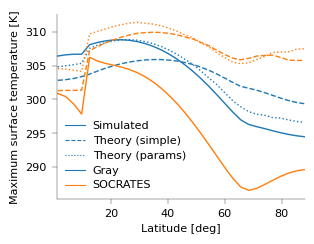

In [49]:
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, width['one_col'])
for key in ['gray', 'soc']:
    ax.plot(ds[key].lat, ds[key].t_surf.max(dim='dayofyear'), color=color_exp[key], label='Simulated' if key=='gray' else None)
    ax.plot(ds[key].lat, temp_surf_eqb[key], color=color_exp[key], linestyle='--', label='Theory (simple)' if key=='gray' else None)
    # plt.plot(ds[key].lat, temp_surf_eqb[key+'_insolation'], color=color_exp[key], linestyle=':')
    ax.plot(ds[key].lat, temp_surf_eqb[key+'_param'], color=color_exp[key], linestyle=':', label='Theory (params)' if key=='gray' else None)
    ax.plot(-20, 300, color=color_exp[key], label=exp_label[key])
# ax.plot(ds[key].lat, ds_dyn.t_surf.max(dim='dayofyear'), color='k', label='Simulated' if key=='gray' else None)
# ax.plot(ds[key].lat, temp_surf_eqb['gray_param_dyn'], color='k', linestyle=':')
ax.set_ylabel('Maximum surface temperature [K]')
ax.set_xlabel('Latitude [deg]')
ax.set_xlim(ax_lims_lat)
ax.legend(ncol=1)
isca_tools.plot.update_fontsize(fig)
isca_tools.plot.update_linewidth(fig)
plt.show()
# isca_tools.savefig(fig, 'max_temp_lat.pdf')

### Theory applied to Full dynamic gray gas simulation
Here, we can see that we expect the hottest day to be at around $20\degree$ from the surface energy budget on this particular day, but there is a Lindzen-Hou type effect where the hottest day is pushed to higher latitudes with reduced amplitude.

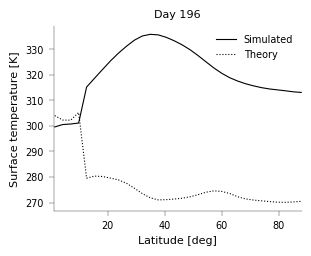

In [50]:
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, width['one_col'])
ind_use = int(ds_dyn.t_surf.isel(lat=ds_dyn.t_surf.max(dim='dayofyear').argmax()).argmax())
ax.plot(ds_dyn.lat, ds_dyn.t_surf.isel(dayofyear=ind_use), color='k', label='Simulated')
ax.plot(ds_dyn.lat, temp_surf_eqb['gray_param_dyn'], color='k', linestyle=':', label='Theory')
ax.set_ylabel('Surface temperature [K]')
ax.set_xlabel('Latitude [deg]')
ax.set_title(f'Day {ind_use}')
ax.legend()
ax.set_xlim(ax_lims_lat)
plt.show()

### Effect of Parameters
Above we see, when we take the parameters at the time of maximum surface temperature at each latitude, then the hottest location is in subtropics, not the pole. This is despite the pole having the most insolation. Below we explore which parameters are the major factor in this. I.e. which parameters can explain why the dotted and dashed orange lines above differ.

I neglect the drag here, as I think as the wind is constant, it would make sense to impose it as a constant i.e. re-run the simulations. Also, hard to interpret. Without it, just have three parameters: insolation, relative humidity and surface - air temperature disequilibrium.

Below I plot the latitudinal variation in parameters on the hottest day at each latitude.

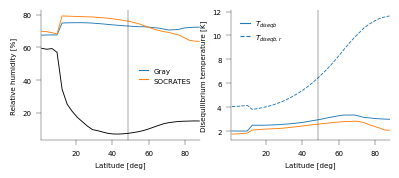

In [51]:
n_lat = ds['soc'].lat.size
fig, ax = plt.subplots(1, 2, sharex=True)
isca_tools.plot.fig_resize(fig, width['two_thirds'])
for key in ['gray', 'soc']:
    ax[0].plot(ds[key].lat, [ds[key].rh.isel(lat=i, dayofyear=ds[key].t_surf.isel(lat=i).argmax())*100 for i in range(n_lat)], label=exp_label[key])
    ax[1].plot(ds[key].lat, [ds[key].temp_diseqb.isel(lat=i, dayofyear=ds[key].t_surf.isel(lat=i).argmax()) for i in range(n_lat)],
               label='$T_{diseqb}$' if key=='gray' else None)
ax[1].plot(ds['gray'].lat, [ds['gray'].temp_diseqb_rad_gray.isel(lat=i, dayofyear=ds[key].t_surf.isel(lat=i).argmax()) for i in range(n_lat)],
           color=color_exp['gray'], linestyle='--', label='$T_{diseqb,r}$')
ax[0].plot(ds[key].lat, [ds_dyn.rh.isel(lat=i, dayofyear=ds_dyn.t_surf.isel(lat=i).argmax())*100 for i in range(n_lat)], color='k')
ax[0].set_ylabel('Relative humidity [%]')
ax[1].set_ylabel('Disequilibrium temperature [K]')
add_legend(ax[0])
add_legend(ax[1])
ax[0].set_xlim(ax_lims_lat)
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
isca_tools.plot.update_fontsize(fig)
isca_tools.plot.update_linewidth(fig)
for i in range(2):
    ax[i].axvline(ds_ref['gray'].lat, color='k', lw=ax_linewidth)
plt.show()
# isca_tools.savefig(fig, 'param_lat')

In [52]:
key = 'soc'
ind_use_swdn_ref = ds[key].swdn_toa.isel(lat=ind_lat_ref).argmax()
temp_max_ref = {key: temp_surf_eqb[key+'_param'][ind_lat_ref] for key in ['gray', 'soc']}

temp_eqb_param = {'gray': {key: np.zeros(n_lat) for key in ['swdn_toa', 'opd', 'rh', 'temp_diseqb', 'temp_diseqb_rad']},
    'soc': {key: np.zeros(n_lat) for key in ['swdn_toa', 'rh', 'temp_diseqb']}}
for i in tqdm(range(n_lat)):
    key = 'soc'
    ind_use_swdn = ds[key].swdn_toa.isel(lat=i).argmax()
    ind_use = ds[key].t_surf.isel(lat=i).argmax()
    ds_use = ds[key].isel(lat=i, dayofyear=ind_use)
    temp_eqb_param['soc']['swdn_toa'][i] = get_temp_equilibrium(ds[key].swdn_toa.isel(lat=i, dayofyear=ind_use_swdn), albedo[key],
                                                         coszen=ds[key].soc_coszen.isel(lat=i, dayofyear=ind_use_swdn),
                                                         rh=ds_ref['soc'].rh, temp_diseqb=ds_ref['soc'].temp_diseqb)
    temp_eqb_param['soc']['rh'][i] = get_temp_equilibrium(ds[key].swdn_toa.isel(lat=ind_lat_ref, dayofyear=ind_use_swdn_ref), albedo[key],
                                                   coszen=ds[key].soc_coszen.isel(lat=ind_lat_ref, dayofyear=ind_use_swdn_ref), rh=ds_use.rh,
                                                   temp_diseqb=ds_ref['soc'].temp_diseqb)
    temp_eqb_param['soc']['temp_diseqb'][i] = get_temp_equilibrium(ds[key].swdn_toa.isel(lat=ind_lat_ref, dayofyear=ind_use_swdn_ref), albedo[key],
                                                         coszen=ds[key].soc_coszen.isel(lat=ind_lat_ref, dayofyear=ind_use_swdn_ref),
                                                         temp_diseqb=ds_use.temp_diseqb, rh=ds_ref['soc'].rh)

    key = 'gray'
    ind_use = ds[key].t_surf.isel(lat=i).argmax()
    ds_use = ds[key].isel(lat=i, dayofyear=ind_use)
    temp_eqb_param[key]['swdn_toa'][i] = get_temp_equilibrium(float(ds[key]['swdn_toa'].isel(lat=i).max()),
                            albedo[key], float(opd_lw_gray(ds_ref[key].lat)), opd_sw_gray, temp_diseqb=float(ds_ref[key].temp_diseqb),
                            rh=float(ds_ref[key].rh), temp_diseqb_rad=float(ds_ref[key].temp_diseqb_rad_gray))
    temp_eqb_param[key]['opd'][i] = get_temp_equilibrium(float(ds[key]['swdn_toa'].isel(lat=ind_lat_ref).max()),
                            albedo[key], float(opd_lw_gray(ds_use.lat)), opd_sw_gray, temp_diseqb=float(ds_ref[key].temp_diseqb),
                            rh=float(ds_ref[key].rh), temp_diseqb_rad=float(ds_ref[key].temp_diseqb_rad_gray))
    temp_eqb_param[key]['rh'][i] = get_temp_equilibrium(float(ds[key]['swdn_toa'].isel(lat=ind_lat_ref).max()),
                            albedo[key], float(opd_lw_gray(ds_ref[key].lat)), opd_sw_gray, temp_diseqb=float(ds_ref[key].temp_diseqb),
                            rh=float(ds_use.rh), temp_diseqb_rad=float(ds_ref[key].temp_diseqb_rad_gray))
    temp_eqb_param[key]['temp_diseqb'][i] = get_temp_equilibrium(float(ds[key]['swdn_toa'].isel(lat=ind_lat_ref).max()),
                            albedo[key], float(opd_lw_gray(ds_ref[key].lat)), opd_sw_gray, temp_diseqb=float(ds_use.temp_diseqb),
                            rh=float(ds_ref[key].rh), temp_diseqb_rad=float(ds_ref[key].temp_diseqb_rad_gray))
    temp_eqb_param[key]['temp_diseqb_rad'][i] = get_temp_equilibrium(float(ds[key]['swdn_toa'].isel(lat=ind_lat_ref).max()),
                            albedo[key], float(opd_lw_gray(ds_ref[key].lat)), opd_sw_gray, temp_diseqb=float(ds_ref[key].temp_diseqb),
                            rh=float(ds_ref[key].rh), temp_diseqb_rad=float(ds_use.temp_diseqb_rad_gray))

for key2 in ['soc', 'gray']:
    temp_eqb_param[key2]['sum'] = sum([temp_eqb_param[key2][key]-temp_max_ref[key2] for key in temp_eqb_param[key2]]) + temp_max_ref[key2]
    temp_eqb_param[key2]['non_linear'] = temp_surf_eqb[f'{key2}_param'] - temp_eqb_param[key2]['sum'] + temp_max_ref[key2]

  0%|          | 0/32 [00:00<?, ?it/s]

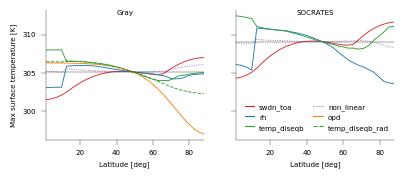

In [53]:
colors_use = {'rh': default_colors[0], 'swdn_toa': default_colors[3], 'temp_diseqb': default_colors[2], 'non_linear': default_colors[4],
              'opd': default_colors[1], 'temp_diseqb_rad': default_colors[2]}
linestyle_use = {key: None for key in colors_use}
linestyle_use['temp_diseqb_rad'] = '--'
linestyle_use['non_linear'] = ':'
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)
isca_tools.plot.fig_resize(fig, width['two_thirds'])
for i, key2 in enumerate(['gray', 'soc']):
    ax[i].set_title(exp_label[key2], y=0.9)
    for key in ['swdn_toa', 'rh', 'temp_diseqb', 'non_linear', 'opd', 'temp_diseqb_rad']:
        if key not in temp_eqb_param[key2]:
            ax[i].plot(-100, 300, color=colors_use[key], linestyle=linestyle_use[key], label=key)
        else:
            ax[i].plot(ds[key2].lat, temp_eqb_param[key2][key], label=key, color=colors_use[key], linestyle=linestyle_use[key])
    # if key2 == 'gray':
    #     for key in ['opd', 'temp_diseqb_rad']:
    #         ax[i].plot(ds[key2].lat, temp_eqb_param[key2][key], label=key, color=colors_use[key], linestyle='--' if key=='temp_diseqb_rad' else None)
    # ax[i].plot(ds[key2].lat, temp_surf_eqb[f'{key2}_param'], color='k', label='sum')
#ax[0].legend(ncol=2)
# ax[0].plot(ds[key2].lat, temp_eqb_param['gray']['swdn_toa'] + temp_eqb_param['gray']['opd'] - temp_max_ref['gray'], color='k', linestyle=':')
# ax[1].plot(ds[key2].lat, temp_eqb_param['soc']['swdn_toa'] + temp_eqb_param['soc']['rh'] - temp_max_ref['soc'], color='k', linestyle=':')
ax[0].set_xlabel('Latitude [deg]')
ax[1].set_xlabel('Latitude [deg]')
ax[0].set_ylabel('Max surface temperature [K]')
ax[0].set_xlim(ax_lims_lat)
add_legend(ax[1], ncol=2)
isca_tools.plot.update_fontsize(fig)
isca_tools.plot.update_linewidth(fig)
for i, key2 in enumerate(['gray', 'soc']):
    ax[i].axhline(temp_max_ref[key2], color='k', lw=ax_linewidth)
# ax[0].set_ylim(296, 313)
plt.show()
# isca_tools.savefig(fig, 'temp_max_param')

### Effect of Insolation and Optical Depth
Above we see that the hottest location is a balance between insolation and optical depth (through relative humidity in SOCRATES case). Below, we plot the hottest temperature due to the co-variation of these parameters assuming all other parameters are constant.

In [54]:
n_rh_2d_plot = 21
rh_2d_plot = np.linspace(0.5, 1.0, n_rh_2d_plot)
opd_2d_plot = np.linspace(0, 6, n_rh_2d_plot)
temp_eqb_2d = {'soc_rh': np.zeros((n_lat, n_rh_2d_plot)), 'gray_opd_pole': np.zeros((n_lat, n_rh_2d_plot))}
pbar = tqdm(total=n_rh_2d_plot*n_lat)
for i in range(n_lat):
    ind_use_swdn = ds['soc'].swdn_toa.isel(lat=i).argmax()
    for j in range(n_rh_2d_plot):
       temp_eqb_2d['soc_rh'][i,j] = get_temp_equilibrium(ds['soc'].swdn_toa.isel(lat=i, dayofyear=ind_use_swdn), albedo['soc'],
                            coszen=ds['soc'].soc_coszen.isel(lat=ind_lat_ref, dayofyear=ind_use_swdn),
                            temp_diseqb=ds_ref['soc'].temp_diseqb, rh=rh_2d_plot[j], bracket=[280, 340])
       temp_eqb_2d['gray_opd_pole'][i,j] = get_temp_equilibrium(float(ds['gray']['swdn_toa'].isel(lat=i).max()),
                                                                albedo['gray'], opd_2d_plot[j], opd_sw_gray,
                                                                bracket=[220, 350], rh=ds_ref['gray'].rh, temp_diseqb=ds_ref['gray'].temp_diseqb,
                                                                temp_diseqb_rad=ds_ref['gray'].temp_diseqb_rad_gray)
       pbar.update(1)

  0%|          | 0/672 [00:00<?, ?it/s]

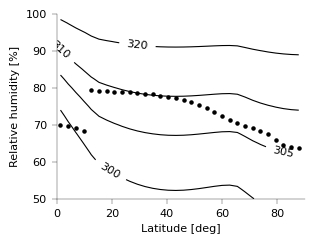

In [55]:
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, width['one_col'])
var_plot = ax.contour(ds['soc'].lat, rh_2d_plot*100, temp_eqb_2d['soc_rh'].transpose(), colors='black', levels=[300, 305, 310, 320])
ax.set_xlim(0, 90)
ax.clabel(var_plot, inline=True)
isca_tools.plot.update_fontsize(fig)
ax.scatter(ds['soc'].lat, [float(ds['soc'].rh.isel(lat=i, dayofyear=ds['soc'].t_surf.isel(lat=i).argmax()))*100 for i in range(n_lat)],
           marker='.', color='k', s=20)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('Relative humidity [%]')
isca_tools.plot.update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig, 'soc_rh_lat.pdf')

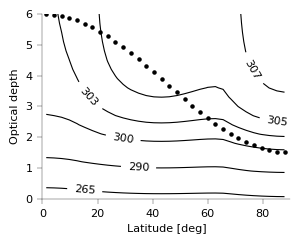

In [56]:
fig, ax = plt.subplots(1, 1)
isca_tools.plot.fig_resize(fig, width['one_col'])
var_plot = ax.contour(ds['soc'].lat, opd_2d_plot, temp_eqb_2d['gray_opd_pole'].transpose(), levels=[265, 290, 300, 303, 305, 307], colors='black')
ax.clabel(var_plot, inline=True)
ax.scatter(ds['soc'].lat, opd_lw_gray(ds['soc'].lat),
           marker='.', color='k', s=20)
ax.set_xlabel('Latitude [deg]')
ax.set_ylabel('Optical depth')
ax.set_xlim(0, 90)
isca_tools.plot.update_fontsize(fig)
plt.show()
# isca_tools.savefig(fig, 'gray_opd_lat.pdf')